Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.5600 - loss: 1.6654 - val_accuracy: 0.4286 - val_loss: 0.6985
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4800 - loss: 10.2584 - val_accuracy: 0.4286 - val_loss: 0.7278
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6000 - loss: 3.3801 - val_accuracy: 0.4286 - val_loss: 0.7760
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7200 - loss: 1.8339 - val_accuracy: 0.4286 - val_loss: 0.8130
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5600 - loss: 2.8948 - val_accuracy: 0.4286 - val_loss: 0.8197
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5600 - loss: 2.3967 - val_accuracy: 0.4286 - val_loss: 0.8216
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6400 - loss: 0.8319 - val_accuracy: 0.4286 - val_loss: 0.8196
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6400 - loss: 0.5177 - val_accuracy: 0.4286 - val_loss: 0.8205
Epoch 9/10
1/1 ━━━━━━━━━

Test Accuracy: 42.86%


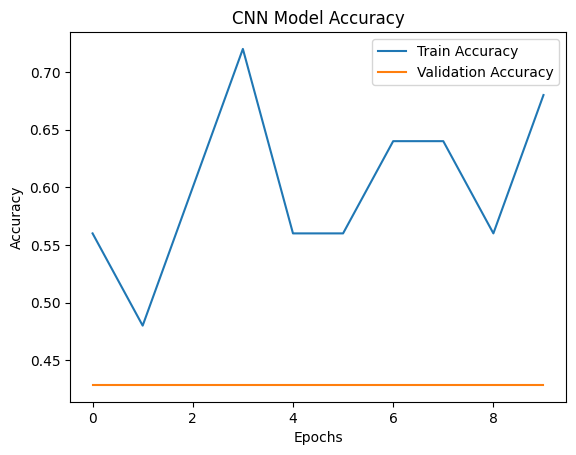

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Classification Result: Benign


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import hashlib
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Set parameters
IMG_SIZE = 128  # Image size for CNN

# Convert assembly text file content to a grayscale image using hashing
def assembly_file_to_image(file_path, img_size=IMG_SIZE):
    with open(file_path, "r", errors="ignore") as f:
        lines = f.readlines()

    # Convert each line into a hash value (better feature extraction than ASCII mapping)
    hash_values = [int(hashlib.md5(line.encode()).hexdigest(), 16) % 256 for line in lines]

    array_size = img_size * img_size
    hash_values = hash_values[:array_size] + [0] * (array_size - len(hash_values))  # Pad/truncate
    img_array = np.array(hash_values, dtype=np.uint8).reshape(img_size, img_size)

    return img_array

# Load dataset from assembly text files
def load_data(dataset_path):
    images, labels = [], []
    for category in ["benign", "malicious"]:
        folder_path = os.path.join(dataset_path, category)
        label = 0 if category == "benign" else 1

        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if file_path.endswith(".txt"):  # Ensure only .txt files are processed
                img = assembly_file_to_image(file_path)  # Convert file to grayscale image
                images.append(img)
                labels.append(label)

    return np.array(images), np.array(labels)

# Define CNN model (with BatchNormalization for better accuracy)
def build_cnn():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),  # Reduced dropout for better learning
        Dense(2, activation='softmax')  # 2 classes: benign & malicious
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Set dataset path (ensure your text files are stored here)
DATASET_PATH =  "/content/assembly_data/"

# Load dataset
X, y = load_data(DATASET_PATH)

# Normalize & reshape data
X = X / 255.0  # Normalize pixel values
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # Add channel dimension
y = to_categorical(y, num_classes=2)

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train CNN model
model = build_cnn()
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save the trained model
model.save("assembly_malware_cnn.h5")

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN Model Accuracy")
plt.show()

# Function to classify an assembly code text file
def classify_assembly_file(file_path):
    model = load_model("assembly_malware_cnn.h5")
    img = assembly_file_to_image(file_path)  # Convert text file to grayscale image
    img = img / 255.0  # Normalize
    img = img.reshape(1, IMG_SIZE, IMG_SIZE, 1)

    prediction = model.predict(img)
    return "Malicious" if np.argmax(prediction) == 1 else "Benign"

test_file_path = "/content/multiplication.txt"
result = classify_assembly_file(test_file_path)
print(f"Classification Result: {result}")

